In [1]:
import librosa
import matplotlib.pyplot as plt
import neptune.new as neptune
import numpy as np
import pytorch_lightning as pl
import soundfile
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import build
from dct import isdct, sdct
from models import *
from mu_law import mu_decode, mu_encode

In [2]:
class DaNet(pl.LightningModule):
    def __init__(self, model_loader, noise=0.0, lr=0.0):
        super().__init__()
        self.save_hyperparameters()
        self.model = eval(model_loader)
        self.lr = lr
        self.output_size = 2**12
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, aux = batch
        inp = F.pad(x, (1, -1)) + torch.randn_like(x) * self.hparams.noise
        x_hat = self.forward(inp)
        loss = F.cross_entropy(x_hat[-self.output_size:], x[-self.output_size:])
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = QHAdam(self.parameters(), lr=self.lr, nus=(0.7, 1.0))
        return {"optimizer": optimizer, "lr_scheduler": torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5**0.001)}

In [3]:
project = neptune.init_project(name="mlxa/MusicBox", api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5NTIzY2UxZC1jMjI5LTRlYTQtYjQ0Yi1kM2JhMGU1NDllYTIifQ==")
project['middle1'].download('model.ckpt')
model = DaNet.load_from_checkpoint('model.ckpt')

Remember to stop your project once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/project#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [4]:
import build
loader = build.dataloader(data='dataset_v6', sample_length=2**13, part=0.1, batch_size=10, shuffle=True)
t, _ = next(iter(loader))
t = t[0][:, :1000]
t.shape

torch.Size([256, 1000])

In [7]:
def generate(model, iters, start):
    print('start')
    model.model.reset(show_progress=True)
    print('here')
    assert start.dim() == 2
    for i in tqdm(range(start.size(1) - 1), desc="Preparing"):
        model.model.generate(start[:, i])
    for _ in tqdm(range(iters), desc="Generating"):
        add = model.model.generate(start[:, -1])
        start = torch.cat([start, add], dim=1)
    return start

In [8]:
x = generate(model, 4096, start=t[:, :10])

start


KeyboardInterrupt: 

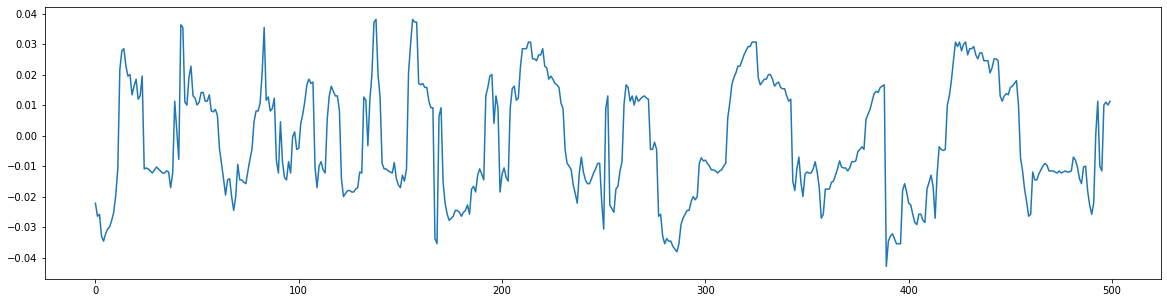

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(x[:, :500].argmax(dim=0))
plt.plot(mu_decode((x[:, :500].argmax(dim=0) - 127.5) / 256))
plt.show()

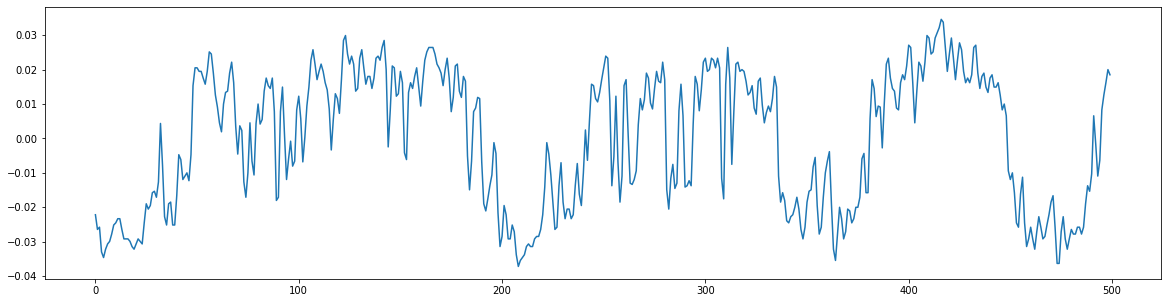

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot((t[:, :500].argmax(dim=0) - 127.5) / 256)
plt.plot(mu_decode((t[:, :500].argmax(dim=0) - 127.5) / 256))
# plt.show()

In [ ]:
soundfile.write('check.wav', mu_decode((x.argmax(dim=0) - 127.5) / 256).numpy(), samplerate=22050)

tensor(187) 3.851004123687744 0.006776399444788694 -7.99296760559082 6.695815563201904
tensor(201) 6.695815563201904 0.11654265969991684 tensor(4.8666e-08) tensor(0.1165) tensor(1.0000)


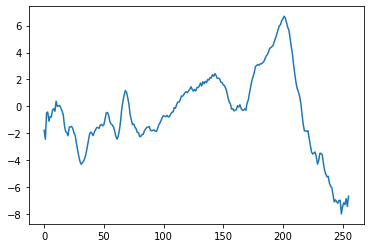

###
tensor(171) 36.48786926269531 0.0 -226.28012084960938 150.41180419921875
tensor(196) 150.41180419921875 0.6093989610671997 tensor(0.) tensor(0.6094) tensor(1.0000)


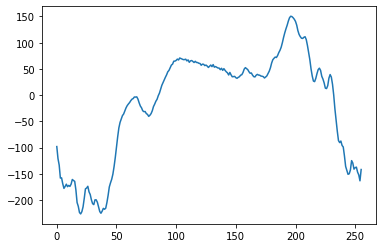

###
tensor(168) 15.209121704101562 0.0 -258.2734680175781 134.9038848876953
tensor(219) 134.9038848876953 0.38541314005851746 tensor(0.) tensor(0.3854) tensor(1.)


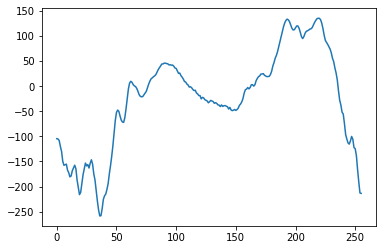

###
tensor(79) 18.547460556030273 2.650696175116824e-41 -183.18310546875 111.62493896484375
tensor(217) 111.62493896484375 0.7020862698554993 tensor(0.) tensor(0.7021) tensor(1.0000)


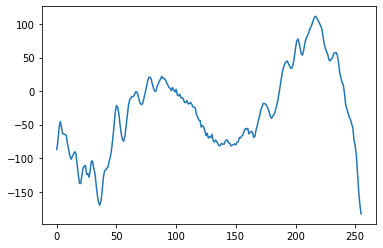

###
tensor(63) 0.011197090148925781 3.776920250620104e-14 -81.8736572265625 30.23619842529297
tensor(216) 30.23619842529297 0.505463182926178 tensor(0.) tensor(0.5055) tensor(1.0000)


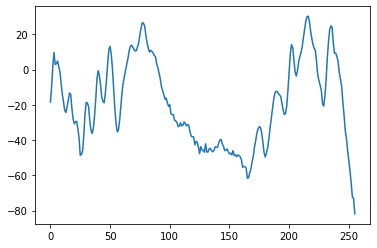

###
tensor(163) -23.327110290527344 2.6314440213355105e-33 -96.34194946289062 51.339786529541016
tensor(40) 51.339786529541016 0.7040719985961914 tensor(0.) tensor(0.7041) tensor(1.)


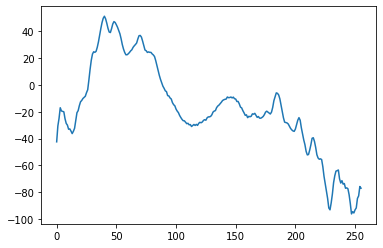

###
tensor(210) -34.655338287353516 6.174121033815144e-41 -92.54825592041016 56.373416900634766
tensor(51) 56.373416900634766 0.21079736948013306 tensor(0.) tensor(0.2108) tensor(1.)


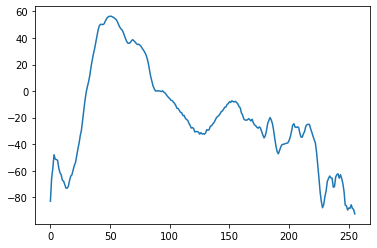

###
tensor(207) -3.9236559867858887 2.674095008600708e-19 -83.66988372802734 38.08068084716797
tensor(60) 38.08068084716797 0.46712028980255127 tensor(0.) tensor(0.4671) tensor(1.0000)


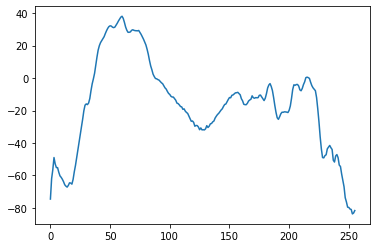

###
tensor(99) -23.88040542602539 1.5172134274647346e-21 -87.76029205322266 22.37866973876953
tensor(176) 22.37866973876953 0.18668429553508759 tensor(0.) tensor(0.1867) tensor(1.0000)


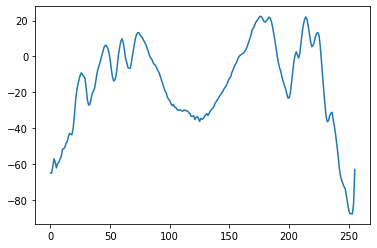

###
tensor(86) 10.938529968261719 5.0918550171773586e-20 -100.48065948486328 54.107688903808594
tensor(175) 54.107688903808594 0.2851041555404663 tensor(0.) tensor(0.2851) tensor(1.)


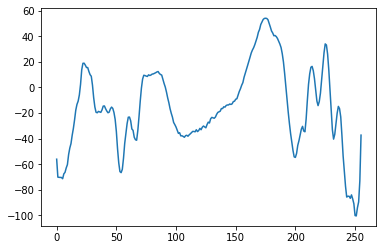

###


In [ ]:
buffer = t[:, :500]
for i in range(10):
    buffer = torch.cat((buffer, torch.zeros((256, 1))), dim=1)
    predict = model(buffer.unsqueeze(0))[0, :, -1]
    prob = F.softmax(predict, dim=0).detach()
    nxt = t[:, 500 + i].argmax()
    idx = predict.argmax()
    print(nxt, predict[nxt].item(), prob[nxt].item(), predict.min().item(), predict.max().item())
    print(idx, predict[idx].item(), prob[idx].item(), prob.min(), prob.max(), prob.sum())
    plt.plot(predict.detach().numpy())
    plt.show()
    print('###')
    buffer[:, -1] = predict